In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import sys
sys.path.append('..')
from tools_plot import regplot, scatterplot
import seaborn as sns
from utils import conditional_probability, probplot, joint_probability, roll_pad
from utils import compute_trials
from collections import defaultdict
import pathlib
%matplotlib inline

In [41]:
# path = pathlib.Path('datasets/datasets')
# data = np.load(path / 'rank_0_10_4_6.npz', allow_pickle=True)
##################################################################
path = pathlib.Path('datasets/datasets/sweep_1/n10_ss1_s3')
# path = pathlib.Path('datasets/datasets/sweep_1/n10_ss4_s6')

data = np.load(path / 'rank_0.npz', allow_pickle=True)

W = data['W']
W_0 = data['W_0']
excitatory_neuron_idx=data['excitatory_neuron_idx']
inhibitory_neuron_idx=data['inhibitory_neuron_idx']
# const = data['const']
# n_neurons = data['n_neurons']
# n_stim = data['n_stim']
# dt = data['dt']
# ref_scale = data['ref_scale']
# abs_ref_scale = data['abs_ref_scale']
# spike_scale = data['spike_scale']
# stim_scale = data['stim_scale']
# abs_ref_strength = data['abs_ref_strength']
# rel_ref_strength = data['rel_ref_strength']
# stim_strength = data['stim_strength']
# alpha = data['alpha']
# n_time_step=data['n_time_step']

# X = data['data']
# W = data['W']
# W_0 = data['W_0']
params=data['params'][()]
const = params['const']
n_neurons = params['n_neurons']
n_stim = params['n_stim']
dt = params['dt']
ref_scale = params['ref_scale']
abs_ref_scale = params['abs_ref_scale']
spike_scale = params['spike_scale']
stim_scale = params['stim_scale']
abs_ref_strength = params['abs_ref_strength']
rel_ref_strength = params['rel_ref_strength']
stim_strength = params['stim_strength']
alpha = params['alpha']
n_time_step=params['n_time_step']

# excitatory_neuron_idx, = np.where(np.any(W_0 > 0, 1))
# inhibitory_neuron_idx, = np.where(np.any(W_0 < 0, 1))
# print(len(excitatory_neuron_idx), len(inhibitory_neuron_idx))

# X = data['data']

# X = []
# for spikes in data['data']:
#     x = np.zeros((n_neurons+1, n_time_step))
#     x[spikes[:,0], spikes[:,1]] = 1
#     X.append(x)

In [42]:
data = {k: data[k][()] for k in data.keys()}

In [43]:
data['data'] = [np.load(fn, allow_pickle=True)['data'][()] for fn in path.glob('*.npz')]
data['all_params'] = [np.load(fn, allow_pickle=True)['params'][()] for fn in path.glob('*.npz')]
data['all_W_0'] = [np.load(fn, allow_pickle=True)['W_0'][()] for fn in path.glob('*.npz')]

In [44]:
print(all([a==b for a, b in zip(data['all_params'], data['all_params'][1:])]))
print(all([np.array_equal(a,b,equal_nan=True) for a, b in zip(data['all_W_0'], data['all_W_0'][1:])]))

True
True


In [45]:
print('const',const)
print('n_neurons',n_neurons)
print('n_stim',n_stim)
print('dt',dt)
print('ref_scale',ref_scale)
print('abs_ref_scale',abs_ref_scale)
print('spike_scale',spike_scale)
print('stim_scale',stim_scale)
print('abs_ref_strength',abs_ref_strength)
print('rel_ref_strength',rel_ref_strength)
print('stim_strength',stim_strength)
print('alpha',alpha)
print('n_time_step',n_time_step)

const 5.0
n_neurons 10
n_stim 5
dt 0.001
ref_scale 10
abs_ref_scale 3
spike_scale 5
stim_scale 2
abs_ref_strength -100
rel_ref_strength -30
stim_strength 1
alpha 0.2
n_time_step 1000000


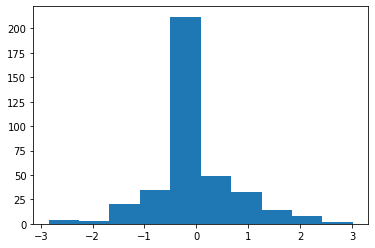

In [46]:
plt.hist(W_0.ravel());

In [47]:
x = np.zeros((n_neurons*2+1, n_time_step))
x[data['data'][0][:,0], data['data'][0][:,1]] = 1
# x[data['data'][0][0], data['data'][0][1]] = 1

In [48]:
times = np.arange(n_time_step) * dt

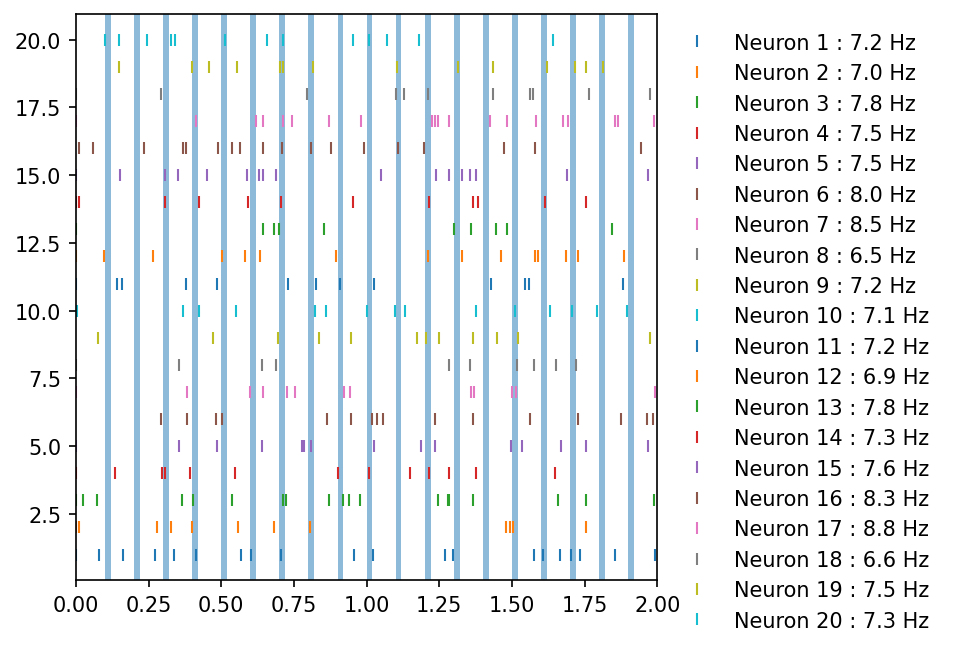

In [49]:
plt.figure(figsize=(5,5), dpi=150)
plot_x = x.copy()
plot_x[plot_x==0.0] = np.nan
for i in range(min(20,len(x))):
    plt.plot(times,plot_x[i]*(i+1), marker='|', ls='none', label=f'Neuron {i+1} : {sum(x[i])/times[-1]:.1f} Hz')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.xlim(0, min(2, times[-1]))
stim_times = times[x[-1].astype(bool)]
for stim_time in stim_times[:min(20, len(times))]:
    plt.axvspan(stim_time, stim_time+2e-2, alpha=0.5)

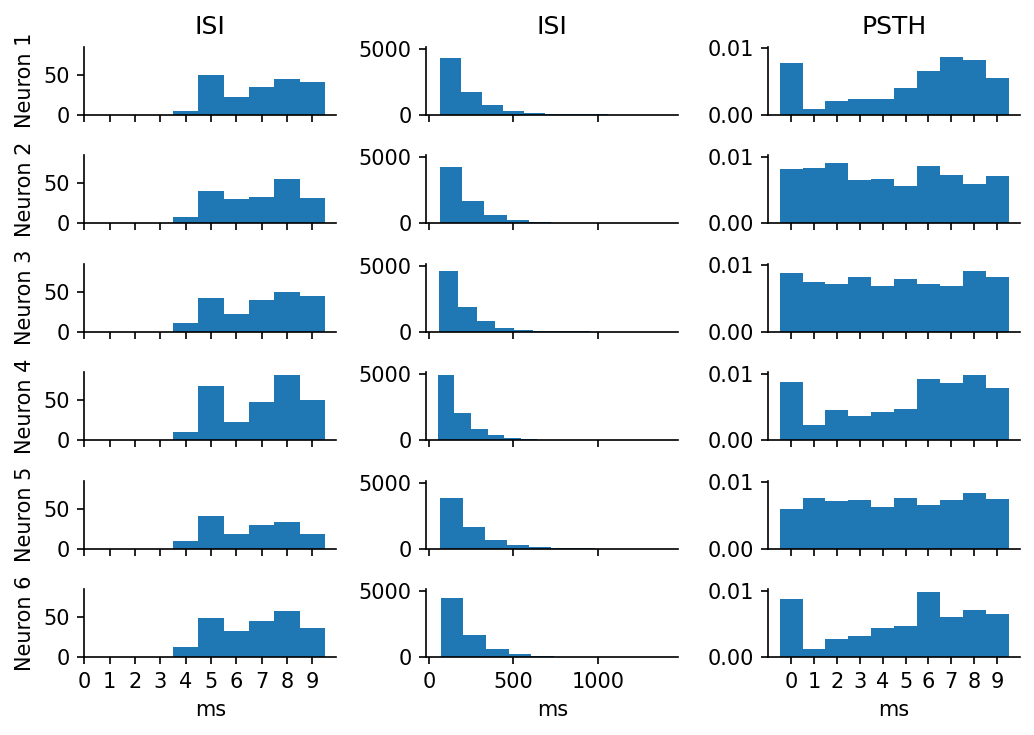

In [50]:
fig, axs = plt.subplots(min(6, n_neurons), 3, figsize=(7,5), dpi=150, sharex='col', sharey='col')
n_step = 10
stim = x[n_neurons].astype(int)

neuron_idx = [*excitatory_neuron_idx[:3], *excitatory_neuron_idx[-4:-1]]

for i, ax in enumerate(axs): 
    neuron = x[neuron_idx[i]]
    t1 = times[neuron.astype(bool)]
    diff = np.diff(t1) * 1000 # ms
    bins = np.arange(0, 0.01, dt) * 1000
    ax[0].hist(diff, bins=bins, align='right')
    ax[0].set_xticks(bins)
    ax[1].hist(diff, align='right')
    psth_bins = np.arange(n_step)
    psth = [(neuron*roll_pad(stim, j)).sum() / stim.sum() for j in psth_bins]
    ax[2].bar(psth_bins, psth, width=1)
    ax[2].set_xticks(psth_bins)
    sns.despine()

for ax in axs[-1]:
    ax.set_xlabel('ms')
    
for i, ax in enumerate(axs.T[0]):
    ax.set_ylabel(f'Neuron {i+1}')
    
for ax, title in zip(axs[0], ['ISI', 'ISI', 'PSTH']):
    ax.set_title(title)
    
plt.tight_layout()

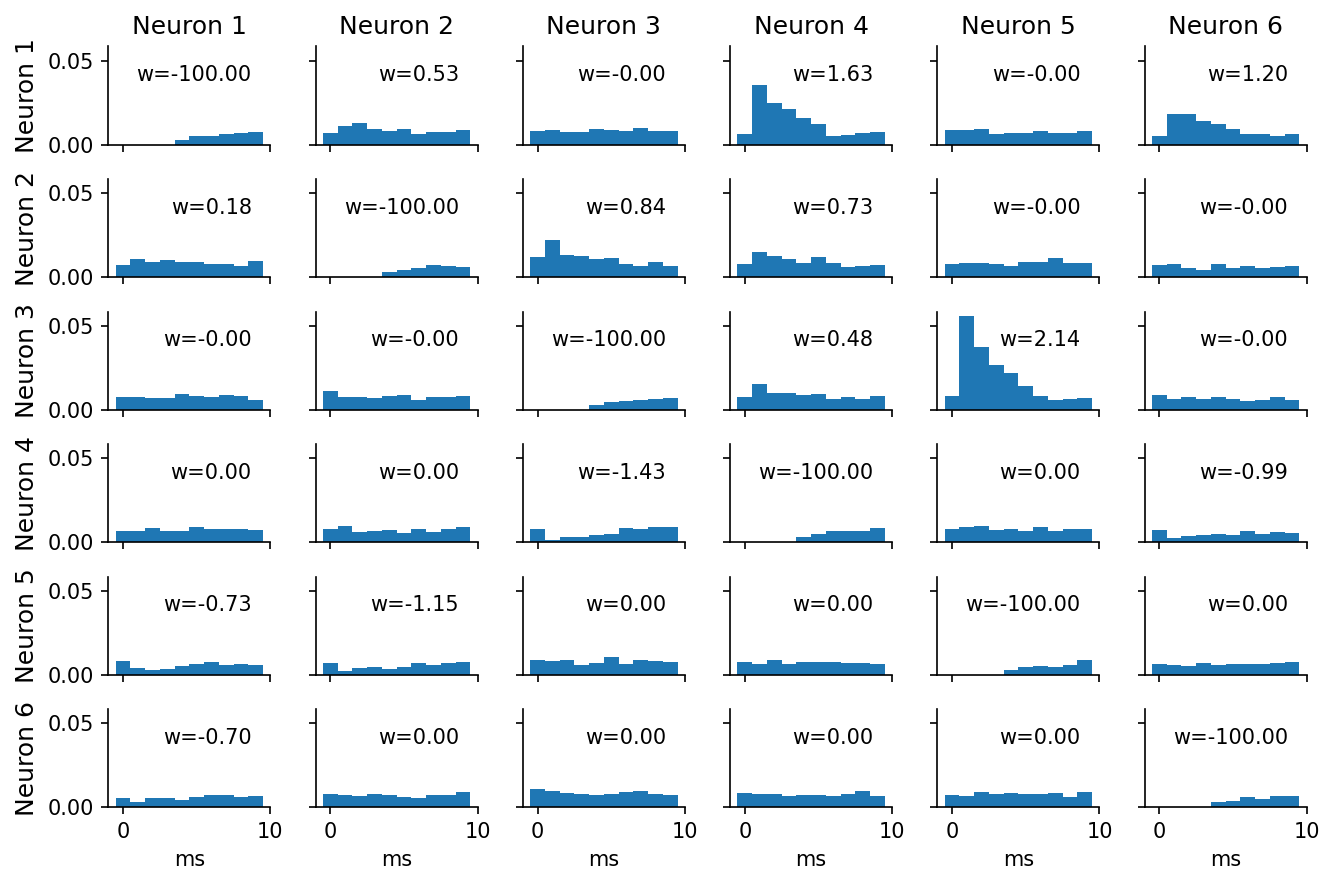

In [51]:
fig, axs = plt.subplots(min(6, n_neurons), min(6, n_neurons), figsize=(9,6), dpi=150, sharex=True, sharey=True)
n_step = 10
neuron_idx = [0, 1, 2, -2, -3, -4]
for i, axr in enumerate(axs):
    for j, ax in enumerate(axr):
        neuron_i = x[neuron_idx[i]]
        neuron_j = x[neuron_idx[j]]
        skip = 1 if i==j else 0 # remove zero lag in neuron autocorrelation
        lags = np.arange(skip, n_step)
        shift = [(neuron_j * roll_pad(neuron_i, jj)).sum() / roll_pad(neuron_i, jj).sum() for jj in lags]
#         shift = [(neuron_j * np.roll(neuron_i, jj)).sum() for jj in lags]
        ax.bar(lags, shift, width=1, label=f'w={W[neuron_idx[i],neuron_idx[j],0]:.2f}')
    
        ax.legend(frameon=False, handlelength=0)
        sns.despine()
        
for ax in axs[-1]:
    ax.set_xlabel('ms')
    
for i, ax in enumerate(axs.T[0]):
    ax.set_ylabel(f'Neuron {i+1}', fontsize=plt.rcParams['axes.titlesize'])
    
for i, ax in enumerate(axs[0]):
    ax.set_title(f'Neuron {i+1}')
    
plt.tight_layout()

# Make trials

In [52]:
# from collections import defaultdict

# trials = defaultdict(list)

# N = 10

# for x in X:
#     stim_index, = np.where(x[-1])
#     for i in stim_index:
#         for ni in range(n_neurons):
#             trials[ni].append(x[ni][i - N:i + N])

# for k,v in trials.items():
#     trials[k] = np.array(v)

trials = compute_trials(data['data'], n_neurons*2, n_time_step)

In [53]:
trials[0].shape

(1119888, 20)

# Process results

In [54]:
x_i, x_j = 11, 13
y_i, y_j = 12, 19
z_i, z_j = 7, 10
    
    
def process(pair, n_trials=None):
    i, j = [int(a) for a in pair.split('_')]
    pre, post = trials[i], trials[j]
    
    n_trials = len(pre) if n_trials is None else n_trials
    
    x = pre[:n_trials, x_i:x_j].sum(1).astype(bool)
    y = post[:n_trials, y_i:y_j].sum(1).astype(bool)
    z = pre[:n_trials, z_i:z_j].sum(1).astype(bool)
    
    y_refractory = (y*z).mean() / z.mean()
    
    y_respons = (y*x).mean() / x.mean()
    
    y_nospike = (y*(1-x)).mean() / (1-x).mean()
    
    y0 = post[:n_trials,0:y_j-y_i].sum(1).astype(bool)
    
    y0_refractory = (y0*z).mean() / z.mean()
    
    y0_respons = (y0*x).mean() / x.mean()
    
    y0_nospike = (y0*(1-x)).mean() / (1-x).mean()
    

    # standard iv
    beta_iv = y_respons - y_refractory
    # OLS
    beta = y_respons - y_nospike
        
    # DiD iv
    beta_iv_did = beta_iv - (y0_respons - y0_refractory) 
    # OLS
    beta_did = beta - (y0_respons - y0_nospike)
    
    result ={
        'source': i,
        'target': j,
        'pair': pair,
        'beta_iv': beta_iv, 
        'beta': beta,
        'beta_iv_did': beta_iv_did, 
        'beta_did': beta_did, 
        'hit_rate': x.mean(),
        'weight': W_0[i, j],
        'source_stim': W[-1, i, 0] > 0,
        'source_stim_strength': W[-1, i, 0],
        'target_stim': W[-1, j, 0] > 0,
        'y_refractory': y_refractory,
        'y_response': y_respons,
        'y_nospike': y_nospike,
        'y0_refractory': y0_refractory,
        'y0_response': y0_respons,
        'y0_nospike': y0_nospike,
        'n_refractory': np.sum(z==1),
        'n_response': np.sum(x==1),
        'n_nospike': np.sum(x==0),
        'n': len(y)
    }
    return result


def compute_time_dependence(i, j, step=10000):
    pair = f'{i}_{j}'
    pre, post = trials[i], trials[j]
    results = []
    start = 0
    for stop in tqdm(range(step, len(pre) + step, step)):
        results.append(process(pair, stop))
    return results


def multi_process(n_trials=None, pairs=None):
    import multiprocessing
    from functools import partial
    
    if pairs is None:
        pairs = [f'{i}_{j}' for i in range(n_neurons*2) for j in range(n_neurons*2) if i != j]
    
    with multiprocessing.Pool() as p:
        results = p.map(partial(process, n_trials=n_trials), pairs)
        
    return results

In [55]:
results = multi_process()

In [56]:
results = pd.DataFrame(results)

In [57]:
results.iloc[:10].T

,0,1,2,3,4,5,6,7,8,9
source,0,0,0,0,0,0,0,0,0,0
target,1,2,3,4,5,6,7,8,9,10
pair,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10
beta_iv,0.01722,-0.000281,-0.000985,0.032171,0.031477,-0.002168,0.028924,0.00037,0.054037,0.008228
beta,0.023444,0.007003,0.002645,0.048133,0.042551,0.0042,0.038442,0.002086,0.066123,0.009297
beta_iv_did,0.021925,0.003297,0.020414,0.033753,0.067245,0.02279,0.028775,0.002365,0.065089,-0.009896
beta_did,0.022244,0.005101,0.002086,0.047149,0.043489,0.001732,0.039742,0.002433,0.066379,0.009278
hit_rate,0.036716,0.036716,0.036716,0.036716,0.036716,0.036716,0.036716,0.036716,0.036716,0.036716
weight,0.527606,-0.0,-0.0,0.995659,1.019482,-0.0,1.202981,-0.0,1.629581,-0.0
source_stim,True,True,True,True,True,True,True,True,True,True


In [58]:
sample = results.query('source_stim and not target_stim and weight >= 0')
# sample = results.query('source_stim and not target_stim')

In [59]:
sample

,source,target,pair,beta_iv,beta,beta_iv_did,beta_did,hit_rate,weight,source_stim,...,y_refractory,y_response,y_nospike,y0_refractory,y0_response,y0_nospike,n_refractory,n_response,n_nospike,n
4,0,5,0_5,0.031477,0.042551,0.067245,0.043489,0.036716,1.019482,True,...,0.067823,0.099300,0.056749,0.089565,0.053796,0.054735,22721,41118,1078770,1119888
5,0,6,0_6,-0.002168,0.004200,0.022790,0.001732,0.036716,-0.000000,True,...,0.074204,0.072037,0.067837,0.086440,0.061482,0.059014,22721,41118,1078770,1119888
6,0,7,0_7,0.028924,0.038442,0.028775,0.039742,0.036716,1.202981,True,...,0.054883,0.083808,0.045366,0.044672,0.044822,0.046122,22721,41118,1078770,1119888
7,0,8,0_8,0.000370,0.002086,0.002365,0.002433,0.036716,-0.000000,True,...,0.055323,0.055693,0.053607,0.051802,0.049808,0.050155,22721,41118,1078770,1119888
8,0,9,0_9,0.054037,0.066123,0.065089,0.066379,0.036716,1.629581,True,...,0.061265,0.115302,0.049179,0.060033,0.048981,0.049237,22721,41118,1078770,1119888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,4,15,4_15,0.011543,0.021900,0.015535,0.022642,0.038632,0.145044,True,...,0.071090,0.082632,0.060732,0.060899,0.056906,0.057649,24237,43264,1076624,1119888
91,4,16,4_16,0.075172,0.108088,0.054173,0.108822,0.038632,1.536003,True,...,0.098321,0.173493,0.065405,0.038866,0.059865,0.060600,24237,43264,1076624,1119888
92,4,17,4_17,0.006217,0.008983,0.006880,0.007740,0.038632,0.234583,True,...,0.050089,0.056305,0.047322,0.048232,0.047568,0.046325,24237,43264,1076624,1119888
93,4,18,4_18,0.004872,0.012163,0.006153,0.014290,0.038632,-0.000000,True,...,0.061765,0.066637,0.054474,0.050212,0.048932,0.051059,24237,43264,1076624,1119888


# Regression analysis

In [60]:
# ill conditions, eigenspectrum, inverse problem, condition number, causal analysis is inverse
# if condition nr is one, OLS should work, condition number larger than one is confounded, too much and IV does not help
# the dial for conditino nr, high baseline weak interaction OLS good, same baseline stronger interactions larger condition nr IV good, keep going high condiiton nr IV does not work
# amount of data prop with cond nr, 10 times larger cond nr 10 times more data.

# make cond prob plots on 50 neuron case to konrad

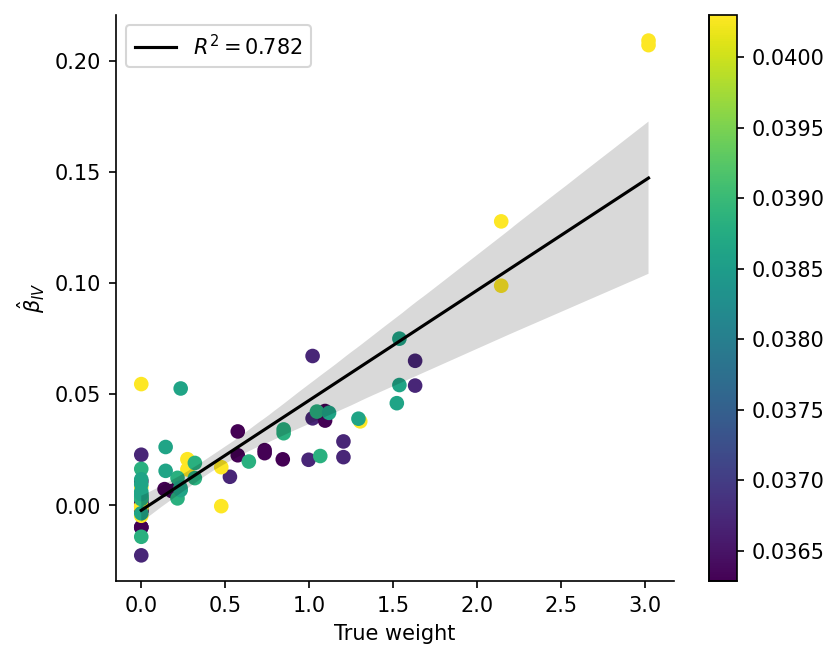

In [61]:
fig, ax = plt.subplots(1,1,figsize=(6,5), dpi=150)
model = regplot(
    'weight', 'beta_iv_did', data=sample, 
    scatter_color=sample['hit_rate'], colorbar=True, ax=ax)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')
sns.despine()

# ylim = ax.get_ylim()
# ylim = [ylim[0], 0.065]
# ax.set_ylim(ylim)

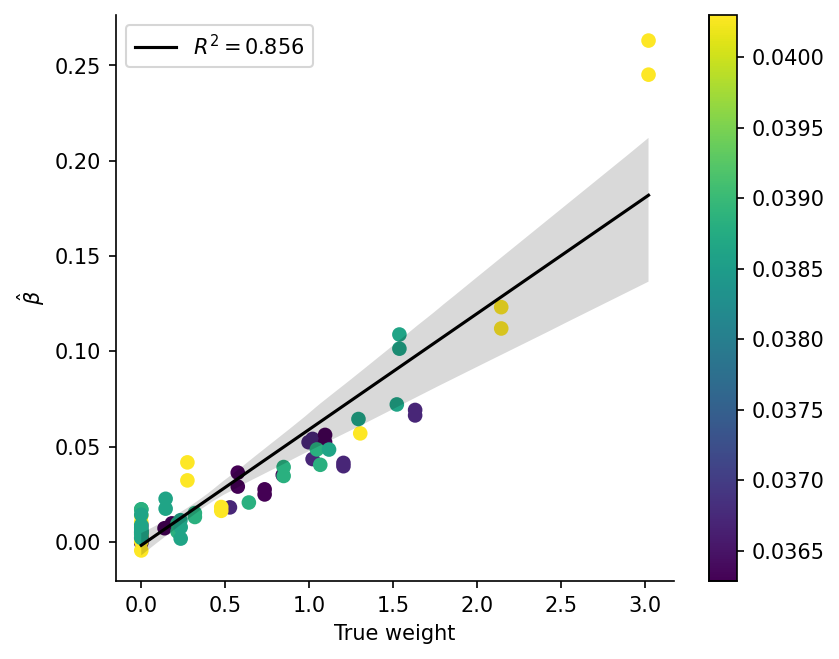

In [62]:
fig, ax = plt.subplots(1,1,figsize=(6,5), dpi=150)
model = regplot(
    'weight', 'beta_did', data=sample, 
    scatter_color=sample['hit_rate'], colorbar=True, ax=ax)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')
sns.despine()

# ax.set_ylim(ylim)

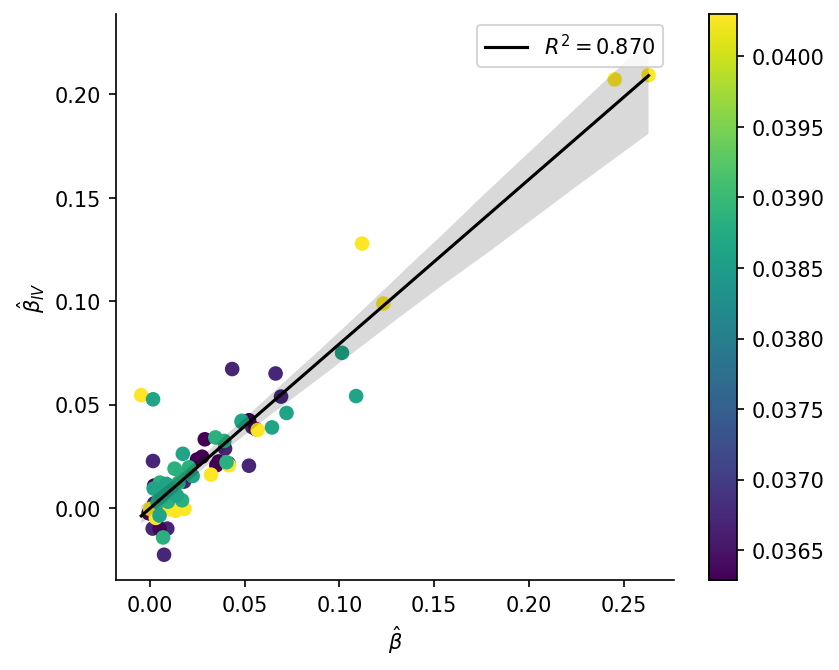

In [63]:
fig, ax = plt.subplots(1,1,figsize=(6,5), dpi=150)
model = regplot(
    'beta_did', 'beta_iv_did', data=sample, 
    scatter_color=sample['hit_rate'], colorbar=True, ax=ax)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel(r'$\hat{\beta}$')
plt.ylabel(r'$\hat{\beta}_{IV}$')
sns.despine()

# False positives

In [64]:
sample_zero = results.query('source_stim and not target_stim and weight < 0.1 and weight >= 0')
sample_zero

,source,target,pair,beta_iv,beta,beta_iv_did,beta_did,hit_rate,weight,source_stim,...,y_refractory,y_response,y_nospike,y0_refractory,y0_response,y0_nospike,n_refractory,n_response,n_nospike,n
5,0,6,0_6,-0.002168,0.004200,0.022790,0.001732,0.036716,-0.0,True,...,0.074204,0.072037,0.067837,0.086440,0.061482,0.059014,22721,41118,1078770,1119888
7,0,8,0_8,0.000370,0.002086,0.002365,0.002433,0.036716,-0.0,True,...,0.055323,0.055693,0.053607,0.051802,0.049808,0.050155,22721,41118,1078770,1119888
9,0,10,0_10,0.008228,0.009297,-0.009896,0.009278,0.036716,-0.0,True,...,0.051186,0.059414,0.050117,0.030809,0.048932,0.048913,22721,41118,1078770,1119888
11,0,12,0_12,-0.000870,0.004981,-0.022512,0.007571,0.036716,-0.0,True,...,0.061573,0.060703,0.055723,0.029576,0.051218,0.053809,22721,41118,1078770,1119888
12,0,13,0_13,0.000852,0.004100,-0.000457,0.005228,0.036716,-0.0,True,...,0.058052,0.058904,0.054804,0.048061,0.049370,0.050498,22721,41118,1078770,1119888
15,0,16,0_16,-0.002023,0.003887,0.000807,0.003775,0.036716,-0.0,True,...,0.075349,0.073326,0.069438,0.063510,0.060679,0.060567,22721,41118,1078770,1119888
17,0,18,0_18,0.002235,0.001434,-0.009864,0.001587,0.036716,-0.0,True,...,0.054091,0.056326,0.054891,0.038731,0.050829,0.050982,22721,41118,1078770,1119888
25,1,7,1_7,0.002619,0.001358,0.010883,0.002335,0.036286,-0.0,True,...,0.045467,0.048085,0.046728,0.053397,0.045132,0.046110,22698,40636,1079252,1119888
26,1,8,1_8,0.002533,0.004890,0.000721,0.004113,0.036286,-0.0,True,...,0.055864,0.058396,0.053507,0.049079,0.050891,0.050114,22698,40636,1079252,1119888
29,1,11,1_11,0.001290,0.000717,-0.002425,-0.000556,0.036286,-0.0,True,...,0.048198,0.049488,0.048771,0.045158,0.048873,0.047600,22698,40636,1079252,1119888


([<matplotlib.axis.XTick at 0x7f18536fa7f0>,
 [Text(1, 0, '$\\beta_{IV}$'), Text(2, 0, '$\\beta$')])

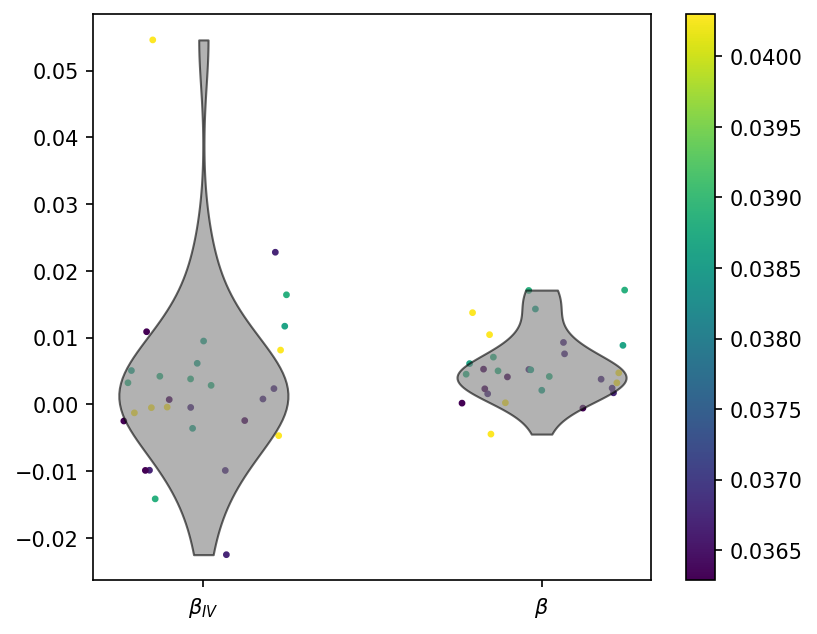

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=150)
pos = np.random.uniform(.25,.75, size=len(sample_zero))
ax.scatter(pos + .5, sample_zero.beta_iv_did, c=sample_zero.hit_rate, s=5)
sc = ax.scatter(pos + 1.5, sample_zero.beta_did, c=sample_zero.hit_rate, s=5)

cb = plt.colorbar(mappable=sc, ax=ax)
cb.ax.yaxis.set_ticks_position('right')

violins = plt.violinplot(sample_zero.loc[:, ['beta_iv_did', 'beta_did']], showextrema=False, bw_method=0.5)
for pc in violins['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
plt.xticks([1, 2], [r'$\beta_{IV}$', r'$\beta$'])

# Error analysis

In [66]:
from scipy.linalg import norm
from scipy.optimize import minimize_scalar

def error(a, df, key):
    return df['weight'] - a * df[key]

def error_norm(a, df, key):
    return norm(error(a, df, key), ord=2)

def min_error(df, key):
    return minimize_scalar(error_norm, args=(df, key))

In [67]:
err_res_beta_iv = min_error(sample, 'beta_iv_did')
err_res_beta = min_error(sample, 'beta_did')

In [68]:
error_norm(err_res_beta_iv.x, sample, 'beta_iv_did')

3.068535085252723

In [69]:
sample['error_beta_iv'] = error(err_res_beta_iv.x, sample, 'beta_iv_did')
sample['error_beta'] = error(err_res_beta.x, sample, 'beta_did')

<ipython-input-69-922291f94ca1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['error_beta_iv'] = error(err_res_beta_iv.x, sample, 'beta_iv_did')
<ipython-input-69-922291f94ca1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['error_beta'] = error(err_res_beta.x, sample, 'beta_did')


In [70]:
err_beta = min_error(sample, 'beta_did').fun
err_beta_iv = min_error(sample, 'beta_iv_did').fun

err_beta_zero = error_norm(1, sample_zero, 'beta_did')
err_beta_iv_zero = error_norm(1, sample_zero, 'beta_iv_did')

In [71]:
print(err_beta, err_beta_iv, err_beta_zero, err_beta_iv_zero)

2.428702122845659 3.068535085252723 0.04057375303193548 0.07315597941614352


# Error convergence

In [72]:
results_step = []
start = 0
step = 10000
steps = np.arange(step, len(trials[0]) + step, step).astype(int)
for stop in tqdm(steps):
    results_step.append(pd.DataFrame(multi_process(stop, sample.pair.values.tolist())))

  0%|          | 0/112 [00:00<?, ?it/s]

In [73]:
errors = defaultdict(list)
for df in results_step:
    errors['beta'].append(min_error(df, 'beta_did').fun)
    errors['beta_iv'].append(min_error(df, 'beta_iv_did').fun)

Text(0, 0.5, '$\\mathrm{error}(\\beta)$')

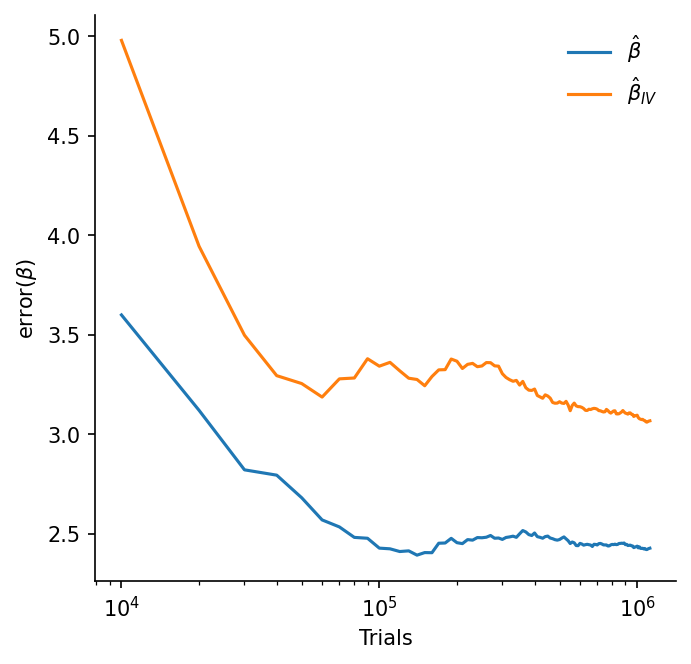

In [74]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
ax.plot(steps, errors['beta'], label=r'$\hat{\beta}$')
ax.plot(steps, errors['beta_iv'], label=r'$\hat{\beta}_{IV}$')
plt.legend(frameon=False)
ax.set_xscale('log')
sns.despine()
ax.set_xlabel('Trials')
ax.set_ylabel(r'$\mathrm{error}(\beta)$')

In [ ]:
results_step_zero = []
for stop in tqdm(steps):
    results_step_zero.append(pd.DataFrame(multi_process(stop, sample_zero.pair.values.tolist())))

  0%|          | 0/112 [00:00<?, ?it/s]

In [ ]:
for df in results_step_zero:
    errors['beta_zero'].append(min_error(df, 'beta_did').fun)
    errors['beta_iv_zero'].append(min_error(df, 'beta_iv_did').fun)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
ax.plot(steps, errors['beta_zero'], label=r'$\hat{\beta}$')
ax.plot(steps, errors['beta_iv_zero'], label=r'$\hat{\beta}_{IV}$')
plt.legend(frameon=False)
ax.set_xscale('log')
sns.despine()
ax.set_xlabel('Trials')
ax.set_ylabel(r'$\mathrm{error}(\beta)$')

# Graph analysis

In [28]:
import networkx as nx

In [29]:
g = nx.DiGraph()

In [30]:
# g.add_nodes_from(np.unique(results.source.values.tolist() + results.target.values.tolist()))

In [31]:
g.add_weighted_edges_from(results.apply(lambda x: (x.source, x.target, x.weight), axis=1).values.tolist())

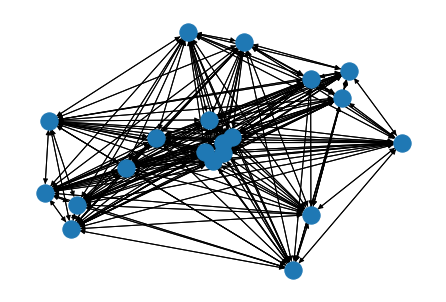

In [54]:
nx.draw(g)

In [110]:
A,C

(2, 19)

In [117]:
paths = list(nx.all_simple_edge_paths(g, A, C, cutoff=2))
print(list(paths)[0])

[(2, 0), (0, 19)]


In [122]:
np.sum([np.sum(g.get_edge_data(*e)['weight']) for p in paths for e in p])

12.0175851058479

# Plot all conditional probabilities

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

fig, axs = plt.subplots(117, 4, figsize=(15,350), dpi=150, sharex=True, sharey=True)
axs = axs.ravel()
for ii, (_, row) in enumerate(sample.iloc[:len(axs)].sort_values('weight').iterrows()):
    ax = axs[ii]
    A, C = row.loc[['source', 'target']].values.T
    cond_A_C = conditional_probability(trials[A], trials[C])
    probplot(cond_A_C, 0, ax=ax, colorbar=False)#, norm=colors.LogNorm(vmin=0.00001, vmax=joints[k].max()))
    ax.set_title(f'{row.pair} {row.weight:.3f}')
    ax.axvline(0, color='gray', lw=0.5, alpha=0.5)
    ax.axhline(0, color='gray', lw=0.5, alpha=0.5)
#     if ii > 10:
#         break
fig.savefig('conditional_probabilities.pdf', bbox_inches='tight')

# Inspect single pair

In [41]:
from utils import conditional_probability, probplot, joint_probability

In [42]:
# sorted_df = sample.sort_values('weight', ascending=False)
sorted_df = sample.sort_values(['error_beta_iv'], ascending=False)
AC_row = sorted_df.iloc[0]
A, C = AC_row.loc[['source', 'target']].values.T

# A,C = 3, 46
sorted_df

,source,target,pair,beta_iv,beta,beta_iv_did,beta_did,hit_rate,weight,source_stim,...,y_nospike,y0_refractory,y0_response,y0_nospike,n_refractory,n_response,n_nospike,n,error_beta_iv,error_beta
53,2,16,2_16,-0.001776,0.043278,0.021105,0.040353,0.591846,3.018435,True,...,0.101585,0.082942,0.060060,0.057136,30865,662801,457087,1119888,2.983156,2.939779
43,2,6,2_6,0.000238,0.037273,0.060105,0.020037,0.591846,3.018435,True,...,0.096417,0.123570,0.063704,0.046468,30865,662801,457087,1119888,2.917967,2.979379
55,2,18,2_18,0.068731,0.315879,0.155972,0.327048,0.591846,2.141870,True,...,0.219529,0.152697,0.065456,0.076624,30865,662801,457087,1119888,1.881155,1.504399
45,2,8,2_8,0.067342,0.301533,0.258833,0.281975,0.591846,2.141870,True,...,0.212496,0.266839,0.075348,0.055790,30865,662801,457087,1119888,1.709218,1.592252
91,4,16,4_16,-0.006063,0.014206,0.006344,0.013334,0.597631,1.536003,True,...,0.118709,0.071624,0.059217,0.058346,26695,669280,450608,1119888,1.525399,1.510012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,1,11,1_11,0.058667,0.251479,0.355904,0.303213,0.658232,-0.000000,True,...,0.512943,0.413096,0.115859,0.167593,58047,737146,382742,1119888,-0.594910,-0.591014
48,2,11,2_11,0.088249,0.397904,0.356469,0.424921,0.591846,-0.000000,True,...,0.442977,0.390734,0.122513,0.149530,30865,662801,457087,1119888,-0.595855,-0.828242
7,0,8,0_8,0.252099,0.354904,0.432367,0.342775,0.569944,-0.000000,True,...,0.188682,0.252851,0.072582,0.060453,25960,638273,481615,1119888,-0.722722,-0.668126
25,1,7,1_7,0.086006,0.237981,0.434170,0.241766,0.658232,-0.000000,True,...,0.401542,0.429307,0.081144,0.084929,58047,737146,382742,1119888,-0.725735,-0.471243


In [43]:
A,C

(2, 16)

In [44]:
tdep = pd.DataFrame(compute_time_dependence(A, C))

  0%|          | 0/112 [00:00<?, ?it/s]

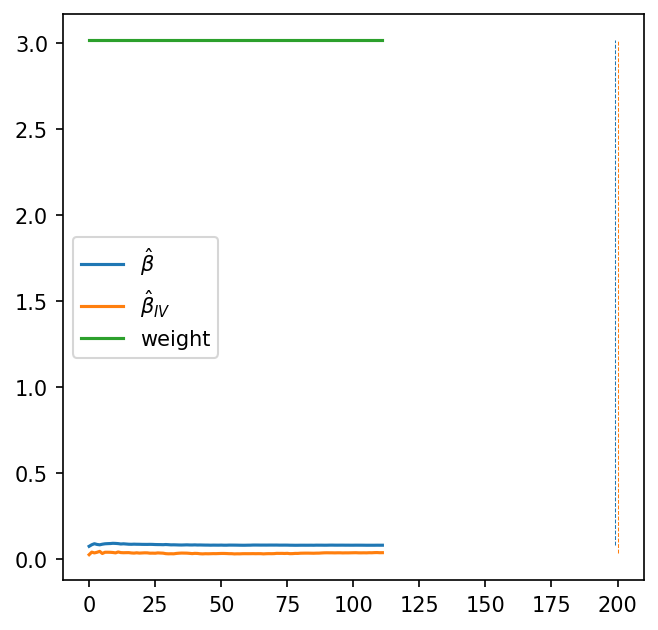

In [45]:
plt.figure(figsize=(5,5), dpi=150)
# plt.plot(tdep.y_response)
# plt.plot(tdep.y_refractory)
# plt.plot(tdep.y_nospike)
# plt.plot(tdep.y0_response)
# plt.plot(tdep.y0_refractory)
# plt.plot(tdep.y0_nospike)
plt.plot(tdep.beta_did*err_res_beta.x, label=r'$\hat{\beta}$')
plt.plot(tdep.beta_iv_did*err_res_beta_iv.x, label=r'$\hat{\beta}_{IV}$')
plt.plot(tdep.weight, label='weight')
plt.plot([199,199], [tdep.weight.values[0] - AC_row.error_beta, tdep.weight.values[0]], color='C0', lw=0.5, ls='--')
plt.plot([200,200], [tdep.weight.values[0] - AC_row.error_beta_iv, tdep.weight.values[0]], color='C1', lw=0.5, ls='--')
plt.legend()

In [46]:
def plot_response(i, j):
    psth_time = np.arange(-10,10)
    pre, post = trials[i], trials[j]
    n_trials = len(pre)
    fig, ax = plt.subplots(2,2, figsize=(8,6), dpi=150, sharey=True)
    ax = ax.ravel()
    ax[0].step(psth_time, pre.sum(0) / n_trials, where='post', label='pre')
    ax[0].step(psth_time, post.sum(0) / n_trials, where='post', label='post')
    ax[0].axvspan(psth_time[x_i], psth_time[x_j], alpha=0.2, color='C0')
    ax[0].axvspan(psth_time[y_i], psth_time[y_j], alpha=0.2, color='C1')
    ax[0].axvspan(psth_time[z_i], psth_time[z_j], alpha=0.2, color='red')
    ax[0].set_xticks(psth_time)
    ax[0].set_xticklabels(psth_time,rotation=45)
    ax[0].legend(frameon=False)
    
    x = pre[:,x_i:x_j].sum(1).astype(bool)
    y = post[:,y_i:y_j].sum(1).astype(bool)
    z = pre[:,z_i:z_j].sum(1).astype(bool)
    
    ax[1].step(psth_time, pre[x==1].sum(0) / n_trials, label='pre respond', where='post')
    ax[1].step(psth_time, pre[z==1].sum(0) / n_trials, label='pre refractory', where='post')
    ax[1].step(psth_time, post[x==1].sum(0) / n_trials, label='post respond', where='post')
    ax[1].step(psth_time, post[z==1].sum(0) / n_trials, label='post refractory', where='post')
    ax[1].axvspan(psth_time[x_i], psth_time[x_j], alpha=0.2, color='C0')
    ax[1].axvspan(psth_time[y_i], psth_time[y_j], alpha=0.2, color='C1')
    ax[1].axvspan(psth_time[z_i], psth_time[z_j], alpha=0.2, color='red')
    ax[1].set_xticklabels(psth_time,rotation=45)
    ax[1].legend(frameon=False)
    ax[1].set_xticks(psth_time)
    ax[1].set_xticklabels(psth_time,rotation=45)
    
    ax[2].step(psth_time, pre[x==1].sum(0) / n_trials, label='pre respond', where='post')
    ax[2].step(psth_time, pre[x==0].sum(0) / n_trials, label='pre nospike', where='post')
    ax[2].step(psth_time, post[x==1].sum(0) / n_trials, label='post respond', where='post')
    ax[2].step(psth_time, post[x==0].sum(0) / n_trials, label='post nospike', where='post')
    ax[2].axvspan(psth_time[x_i], psth_time[x_j], alpha=0.2, color='C0')
    ax[2].axvspan(psth_time[y_i], psth_time[y_j], alpha=0.2, color='C1')
    ax[2].axvspan(psth_time[z_i], psth_time[z_j], alpha=0.2, color='red')
    ax[2].set_xticklabels(psth_time,rotation=45)
    ax[2].legend(frameon=False)
    ax[2].set_xticks(psth_time)
    ax[2].set_xticklabels(psth_time,rotation=45)
#     ax[2].set_title()
    
    ax[3].remove()
    
    sns.despine()
    

<ipython-input-46-4cf7f8762946>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(psth_time,rotation=45)
<ipython-input-46-4cf7f8762946>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(psth_time,rotation=45)


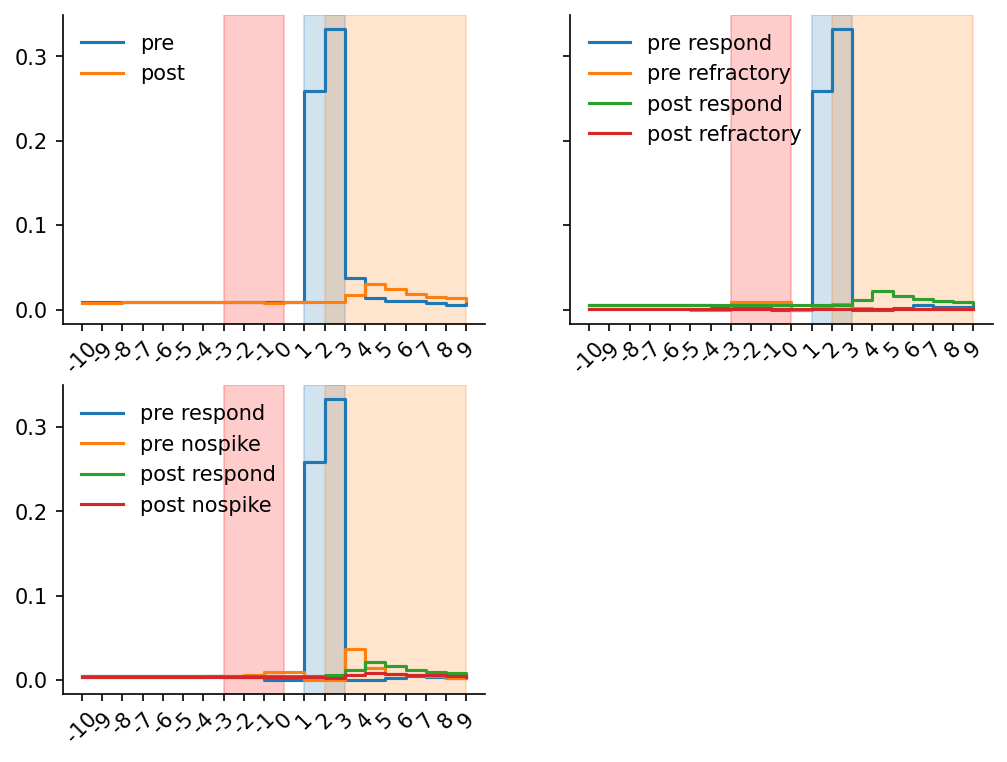

In [47]:
plot_response(A, C)

In [49]:
process(f'{A}_{C}')

{'source': 2,
 'target': 16,
 'pair': '2_16',
 'beta_iv': -0.0017761022767595336,
 'beta': 0.04327788525167173,
 'beta_iv_did': 0.021105481821095833,
 'beta_did': 0.04035335710962323,
 'hit_rate': 0.5918457917220293,
 'weight': 3.0184348904608553,
 'source_stim': True,
 'source_stim_strength': 1.0,
 'target_stim': False,
 'y_refractory': 0.14663858739672767,
 'y_response': 0.14486248511996813,
 'y_nospike': 0.1015845998682964,
 'y0_refractory': 0.08294184351206868,
 'y0_response': 0.060060259414213314,
 'y0_nospike': 0.057135731272164814,
 'n_refractory': 30865,
 'n_response': 662801,
 'n_nospike': 457087,
 'n': 1119888}

In [51]:
N = 10

In [52]:
cond_A_A = conditional_probability(trials[A][:,:N], trials[A][:,N:])

<AxesSubplot:>

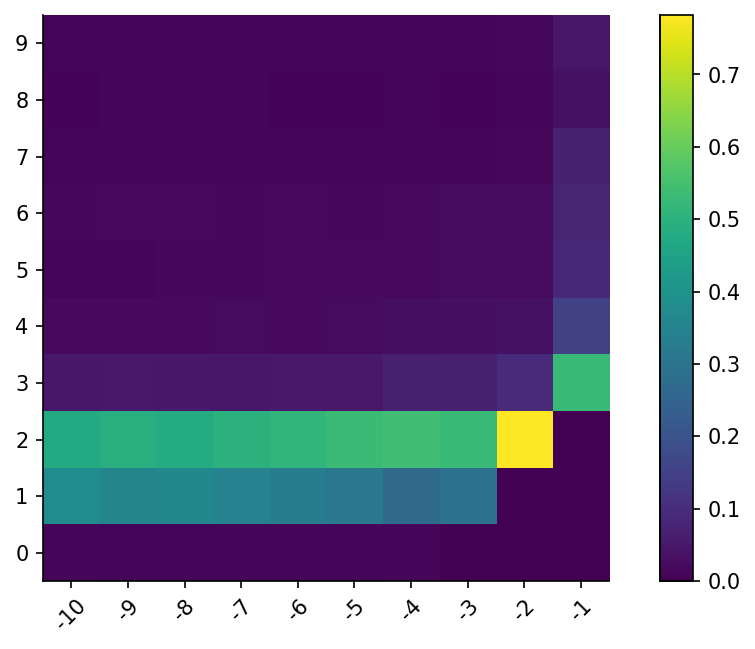

In [53]:
probplot(cond_A_A, 0, *[-10,0,0,10])

In [54]:
cond_A_C = conditional_probability(trials[A], trials[C])

<AxesSubplot:>

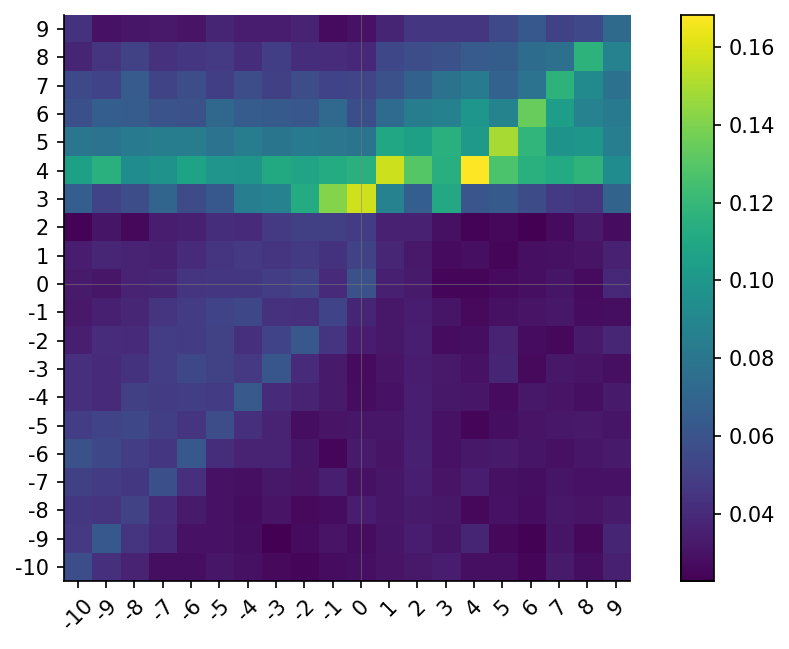

In [55]:
probplot(cond_A_C, 0, grid='zero')

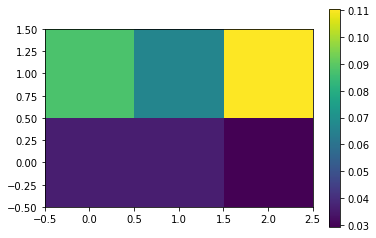

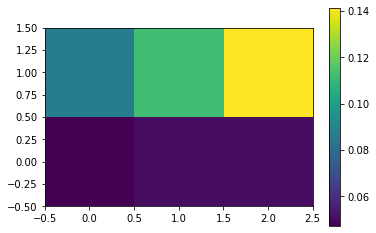

In [56]:
plt.figure()
im = plt.imshow(cond_A_C[12:14,11:14], origin='lower')
plt.colorbar(im)

plt.figure()
im = plt.imshow(cond_A_C[12:14,7:10], origin='lower')
plt.colorbar(im)

In [31]:
cond_A_C[12:14,11:14].sum() - cond_A_C[12:14,7:10].sum()

0.7999999999999999